In [48]:
#  Beauce, France, Known for intensive cereal farming and rotational crops.
#  Low cloud cover, easy access on SentinelHub. Location: 48.3°N, 1.5°E


# ✅ Step 1: Area of Interest – Beauce, France

# 📍 Region: Beauce Plateau, south of Paris — a major cereal-producing zone
# 🗺️ Bounding Box (WGS84):

# Longitude: 1.40°E to 1.65°E  
# Latitude: 48.20°N to 48.45°N

# This region typically covers:

#     Wheat or barley in spring (March)

#     Corn or sunflower in late summer (August–September)

# 🛰️ Suggested Sentinel-2 Tile: T31UDQ
# 🧭 CRS (for SentinelHub): UTM zone 31N (EPSG:32631)
# 📥 Step 2: Image Pair Selection

# Let’s pick a pair with visible crop rotation and low cloud cover:
# Date	Description	Cloud Cover	Notes
# 2021-08-15	Late summer — post-harvest patterns	<5%	Many bare or newly planted fields
# 2022-03-20	Early spring — green early wheat growth	<5%	Distinct texture vs summer
# We can use SentinelHub Playground or EO Browser to check and confirm these.


import os
import numpy as np
from dotenv import load_dotenv
from sentinelhub import (
    SentinelHubRequest, SentinelHubDownloadClient,
    DataCollection, MimeType, CRS, BBox, bbox_to_dimensions,
    SHConfig, SentinelHubCatalog
)
from datetime import datetime
from tqdm import tqdm

# === SET YOUR CREDENTIALS HERE ===
# CLIENT_ID = 'f20a4c96-3a22-4db5-8884-084e9d61a6fb'
# CLIENT_SECRET = 'XsttvLAPvypJapKQ9HIcEwGT5jy528Gt'
# Load credentials
load_dotenv()
config = SHConfig()
config.sh_client_id = os.getenv("CLIENT_ID")
config.sh_client_secret = os.getenv("CLIENT_SECRET")

assert config.sh_client_id and config.sh_client_secret, "Missing credentials."

# Choose bounding box for patch (e.g., small region in Iowa, USA)
# Format: (min_lon, min_lat, max_lon, max_lat)
bbox_coords = (48.20, 1.40, 48.40, 1.60)  # Sample: US Midwest farmland
bbox = BBox(bbox=bbox_coords, crs=CRS.WGS84)
resolution = 10  # meters/pixel
size = bbox_to_dimensions(bbox, resolution=resolution)

# Sentinel-2 L2A 13-band configuration
evalscript = """
// Output: all 13 bands
// B01 to B12 + AOT
// Total: 13 bands, like OSCD
// Resolution: 10m for B02, B03, B04, B08; others upsampled

// Map bands to index
// Index: 0-12 => B01-B12 and AOT (13th band)

function setup() {
  return {
    input: [
      "B01", "B02", "B03", "B04", "B05", "B06",
      "B07", "B08", "B8A", "B09", "B11", "B12", "AOT"
    ],
    output: {
      bands: 13,
      sampleType: "FLOAT32"
    }
  };
}

function evaluatePixel(sample) {
  return [
    sample.B01, sample.B02, sample.B03, sample.B04, sample.B05,
    sample.B06, sample.B07, sample.B08, sample.B8A, sample.B09,
    sample.B11, sample.B12, sample.AOT
  ];
}
"""

def download_patch(date_str, save_path):
    request = SentinelHubRequest(
        data_folder=save_path,
        evalscript=evalscript,
        input_data=[
            SentinelHubRequest.input_data(
                data_collection=DataCollection.SENTINEL2_L2A,
                time_interval=(date_str, date_str)
            )
        ],
        responses=[
            SentinelHubRequest.output_response("default", MimeType.TIFF)
        ],
        bbox=bbox,
        size=size,
        config=config
    )  


    data = request.get_data(save_data=True)[0]
    npy_path = os.path.join(save_path, f"{date_str}.npy")
    np.save(npy_path, data)
    print(f"Saved {npy_path}")
    return npy_path

In [49]:
if __name__ == "__main__":
    save_dir = "./data/patches/crop_rotation_beuce_2020/"
    os.makedirs(save_dir, exist_ok=True)

    date_old = "2021-08-15"
    date_new = "2022-03-20"

    print("Downloading old image...")
    old_path = download_patch(date_old, save_dir)

    print("Downloading new image...")
    new_path = download_patch(date_new, save_dir)

    print("Done! You can now generate a binary change map from these two .npy files.")

Saved ./data/patches/crop_rotation_beuce_2020/2021-08-15.npy
Saved ./data/patches/crop_rotation_beuce_2020/2022-03-20.npy
Done! You can now generate a binary change map from these two .npy files.


In [31]:
import numpy as np
img_old = np.transpose(np.load("data/patches/crop_rotation_beuce_2020/2021-08-15.npy"), (2, 0, 1))  # Now shape: (13, 1104, 837)
img_new = np.transpose(np.load("data/patches/crop_rotation_beuce_2020/2022-03-20.npy"), (2, 0, 1))  # Same


print("Old shape:", img_old.shape)
print("New shape:", img_new.shape)

Old shape: (13, 1104, 837)
New shape: (13, 1104, 837)


In [32]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os

def compute_ndvi(image):
    """
    image: np.ndarray of shape (13, H, W) — Sentinel-2 bands
    Returns NDVI image of shape (H, W)
    NDVI = (NIR - RED) / (NIR + RED)
    Band 8 = NIR, Band 4 = RED
    """
    nir = image[7].astype(np.float32)  # Band 8
    red = image[3].astype(np.float32)  # Band 4
    ndvi = (nir - red) / (nir + red + 1e-6)
    return ndvi

def create_change_map(img_old, img_new, threshold=0.1):
    """
    Computes binary NDVI change map
    Inputs:
        img_old, img_new: np.ndarray with shape (13, H, W)
    Returns:
        Binary mask (H, W), dtype=uint8
    """
    ndvi_old = compute_ndvi(img_old)
    ndvi_new = compute_ndvi(img_new)
    diff = np.abs(ndvi_new - ndvi_old)
    cm = (diff > threshold).astype(np.uint8)
    return cm

def save_change_map_png(cm, save_path):
    """
    Save binary change mask as a .png file (like OSCD)
    """
    img = Image.fromarray((cm * 255).astype(np.uint8))  # 0 or 255
    img.save(save_path)

Change map shape: (1104, 837)


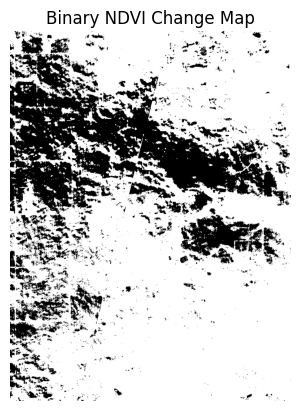

In [33]:
change_map = create_change_map(img_old, img_new)
print("Change map shape:", change_map.shape)  # Should be (H, W)

save_path = "data/patches/crop_rotation_iowa_2020/change_map.png"
save_change_map_png(change_map, save_path)

# Optional: Display for verification
plt.imshow(change_map, cmap="gray")
plt.title("Binary NDVI Change Map")
plt.axis("off")
plt.show()

In [41]:
img_old = np.transpose(np.load("data/patches/crop_rotation_punjab_2020/2020-04-01.npy"), (2, 0, 1))  # Now shape: (13, 1104, 837)
img_new = np.transpose(np.load("data/patches/crop_rotation_punjab_2020/2020-10-01.npy"), (2, 0, 1))  # Same
print("Old shape:", img_old.shape)
print("New shape:", img_new.shape)
change_map = create_change_map(img_old, img_new)
print("Change map shape:", change_map.shape)  # Should be (H, W)

Old shape: (13, 1104, 837)
New shape: (13, 1104, 837)
Change map shape: (1104, 837)


In [1]:
def visualize_patch(img_old, img_new, cm):

    rgb_old = np.stack([img_old[3], img_old[2], img_old[1]], axis=-1)
    rgb_new = np.stack([img_new[3], img_new[2], img_new[1]], axis=-1)
    #print(rgb_new.shape)

    ndvi_old = compute_ndvi(img_old)
    ndvi_new = compute_ndvi(img_new)

    plt.figure(figsize=(15, 8))

    plt.subplot(2, 3, 1)
    plt.imshow(rgb_old / np.max(rgb_old))
    #print(rgb_old)
    plt.title("Old RGB")
    plt.axis("off")

    plt.subplot(2, 3, 2)
    plt.imshow(rgb_new / np.max(rgb_new))
    #print(rgb_new)
    plt.title("New RGB")
    plt.axis("off")

    plt.subplot(2, 3, 3)
    plt.imshow(cm, cmap="gray")
    plt.title("Change Map")
    plt.axis("off")

    plt.subplot(2, 3, 4)
    plt.imshow(ndvi_old, cmap="RdYlGn")
    plt.title("NDVI Old")
    plt.axis("off")

    plt.subplot(2, 3, 5)
    plt.imshow(ndvi_new, cmap="RdYlGn")
    plt.title("NDVI New")
    plt.axis("off")

    plt.tight_layout()
    plt.show()


(1104, 837, 3)


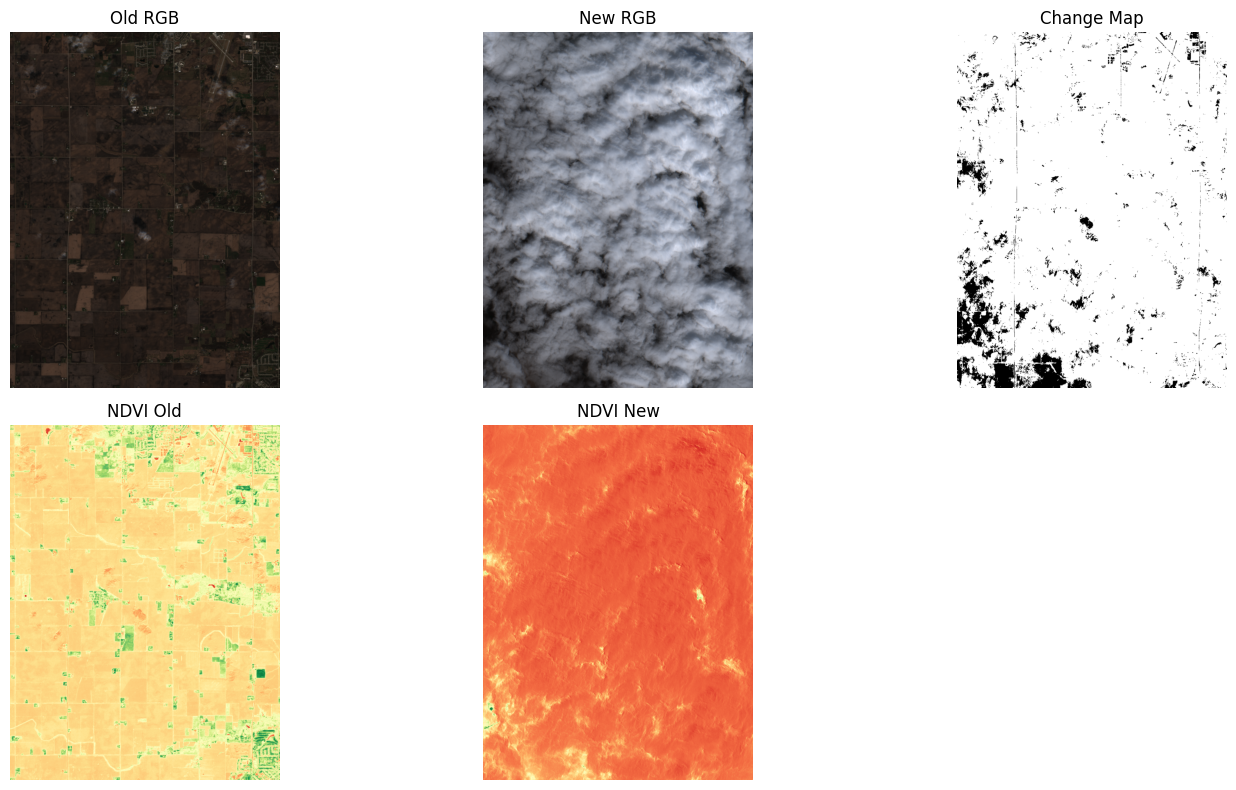

In [42]:
visualize_patch(img_old, img_new, change_map)

Old shape: (13, 1104, 837)
New shape: (13, 1104, 837)
Change map shape: (1104, 837)
(1104, 837, 3)
[[[0.0929 0.0751 0.0626]
  [0.0762 0.0637 0.0509]
  [0.0722 0.0608 0.0493]
  ...
  [0.0703 0.0572 0.0459]
  [0.0631 0.0518 0.0425]
  [0.0601 0.0492 0.0377]]

 [[0.0958 0.0772 0.0668]
  [0.074  0.0595 0.0447]
  [0.0708 0.0641 0.0514]
  ...
  [0.0801 0.0644 0.0531]
  [0.0608 0.0533 0.0432]
  [0.0612 0.052  0.0408]]

 [[0.1001 0.0816 0.0672]
  [0.0782 0.0722 0.0514]
  [0.0893 0.0839 0.0671]
  ...
  [0.063  0.0527 0.0422]
  [0.0563 0.0461 0.0368]
  [0.0639 0.0518 0.0456]]

 ...

 [[0.0888 0.0908 0.0583]
  [0.0966 0.0953 0.0708]
  [0.0953 0.0924 0.0603]
  ...
  [0.1144 0.102  0.0797]
  [0.0881 0.0907 0.0822]
  [0.0698 0.0628 0.0561]]

 [[0.0777 0.0841 0.0565]
  [0.083  0.0857 0.0587]
  [0.083  0.0861 0.0556]
  ...
  [0.0666 0.0642 0.0515]
  [0.072  0.0776 0.0593]
  [0.0615 0.0615 0.0503]]

 [[0.0752 0.0745 0.0541]
  [0.0756 0.0866 0.0571]
  [0.0937 0.0891 0.0638]
  ...
  [0.0548 0.0585 0.0411]

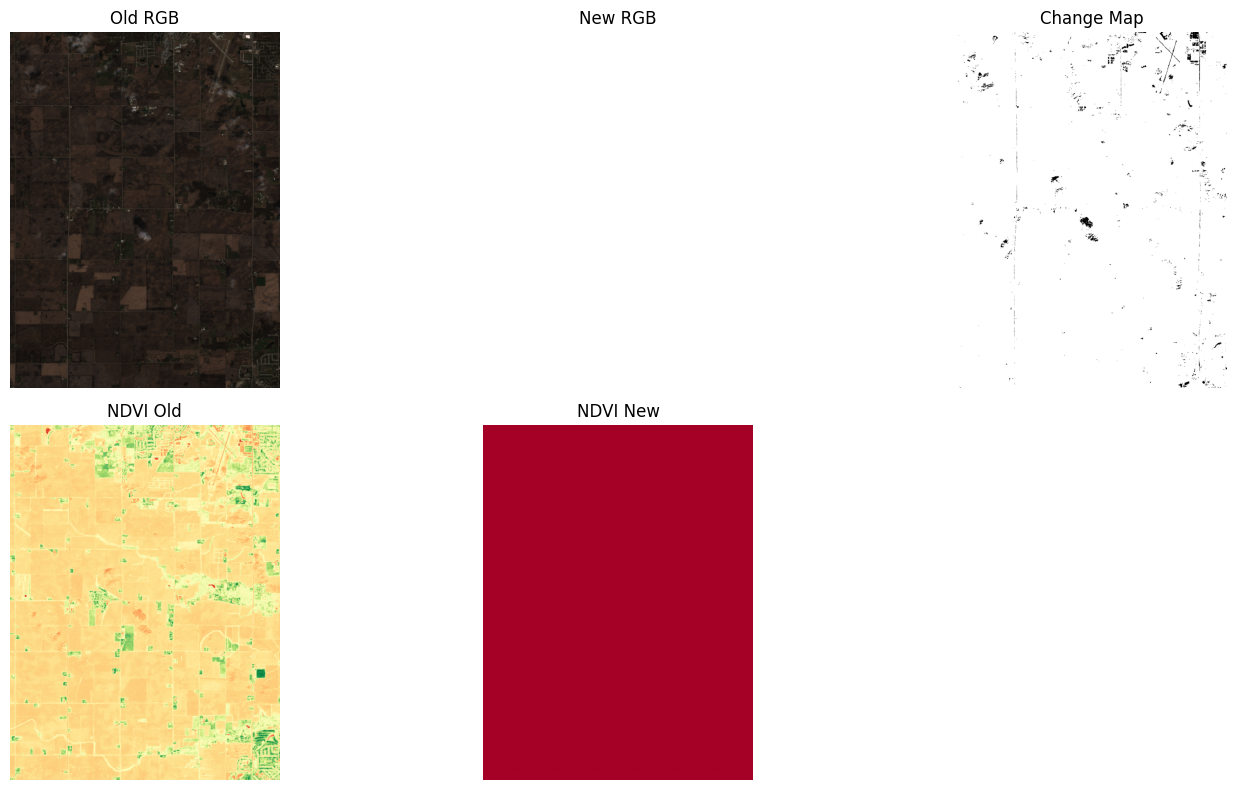

In [56]:
img_old = np.transpose(np.load("data/patches/crop_rotation_occitanie_2020/2020-04-01.npy"), (2, 0, 1))  # Now shape: (13, 1104, 837)
img_new = np.transpose(np.load("data/patches/crop_rotation_occitanie_2020/2020-09-15.npy"), (2, 0, 1))  # Same
print("Old shape:", img_old.shape)
print("New shape:", img_new.shape)
change_map = create_change_map(img_old, img_new)
print("Change map shape:", change_map.shape)  # Should be (H, W)
visualize_patch(img_old, img_new, change_map)

Old shape: (13, 1104, 837)
New shape: (13, 1104, 837)
Change map shape: (1104, 837)
(1104, 837, 3)


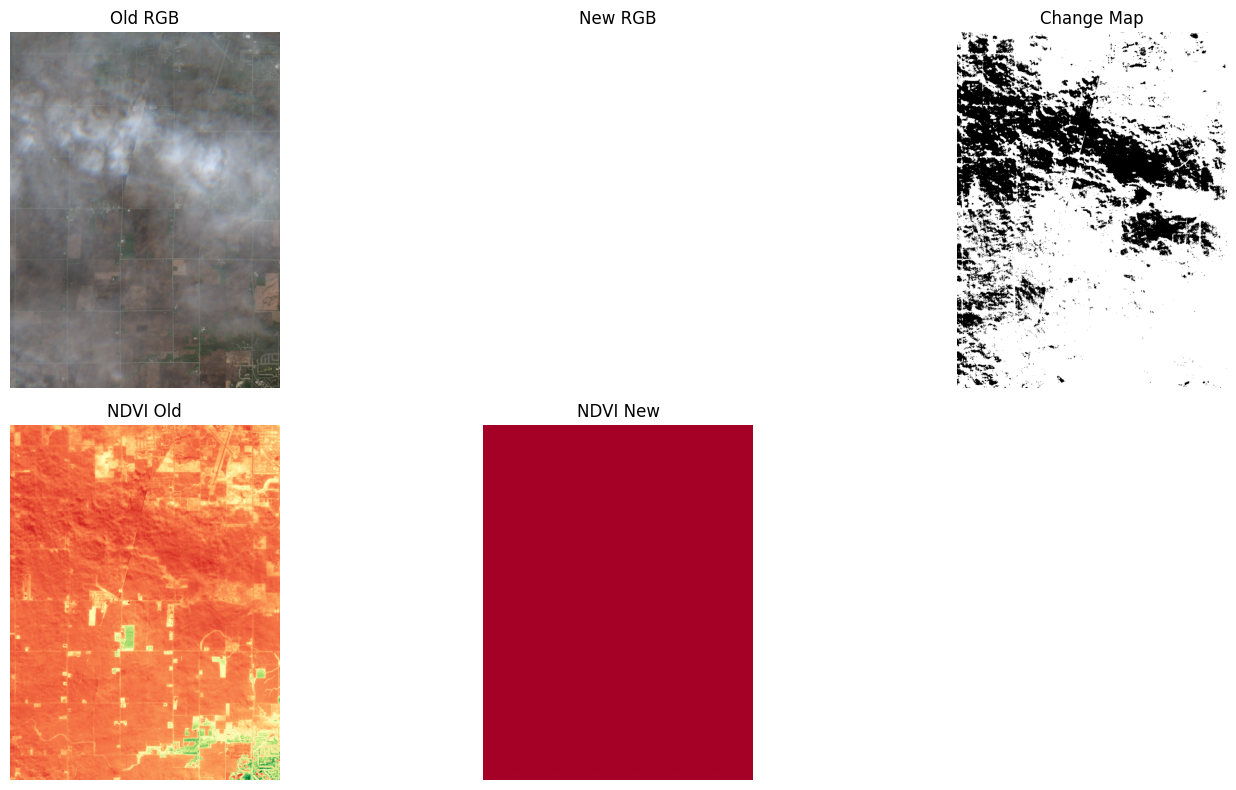

In [45]:
img_old = np.transpose(np.load("data/patches/crop_rotation_matogrosso_2020/2020-05-01.npy"), (2, 0, 1))  # Now shape: (13, 1104, 837)
img_new = np.transpose(np.load("data/patches/crop_rotation_matogrosso_2020/2020-10-15.npy"), (2, 0, 1))  # Same
print("Old shape:", img_old.shape)
print("New shape:", img_new.shape)
change_map = create_change_map(img_old, img_new)
print("Change map shape:", change_map.shape)  # Should be (H, W)
visualize_patch(img_old, img_new, change_map)

Old shape: (13, 2210, 2230)
New shape: (13, 2210, 2230)
Change map shape: (2210, 2230)
(2210, 2230, 3)


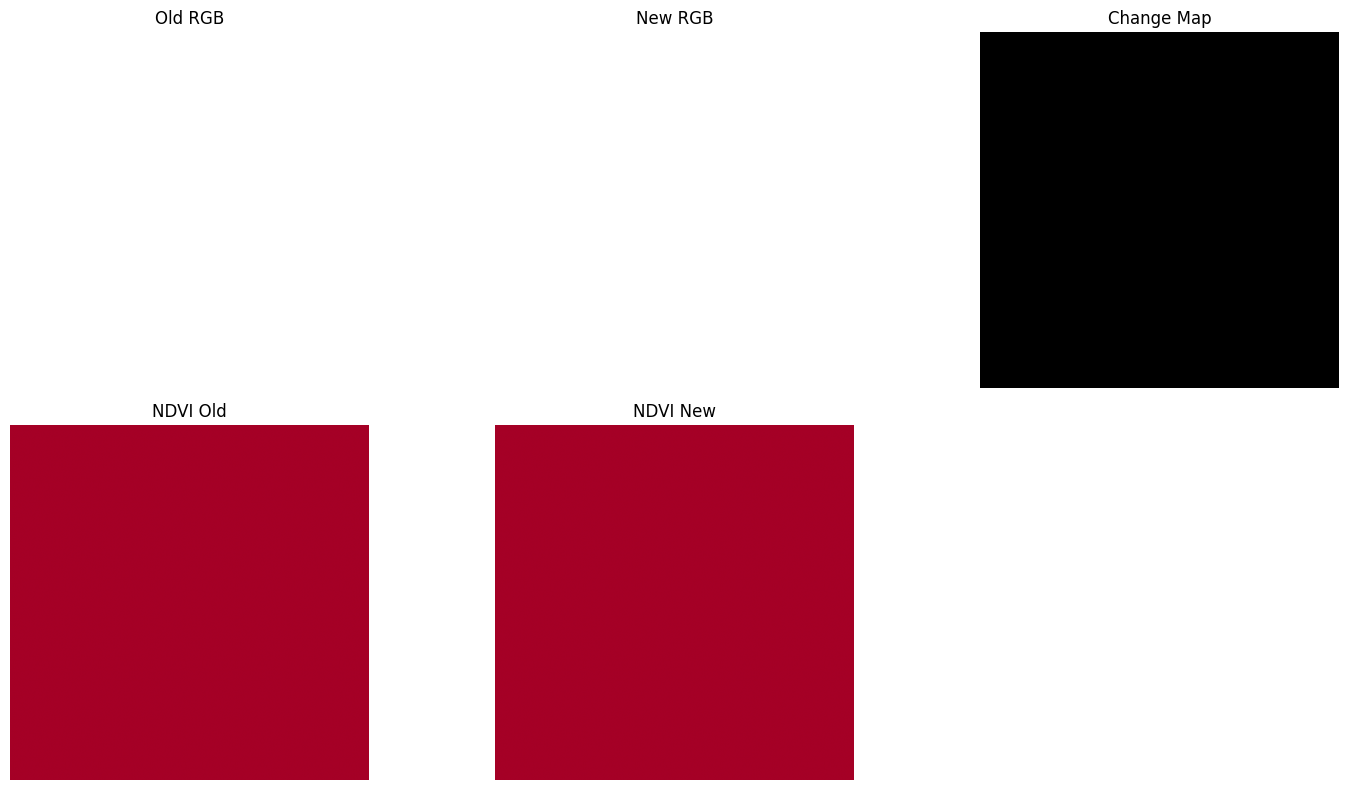

In [53]:
img_old = np.transpose(np.load("data/patches/crop_rotation_beuce_2020/2021-08-15.npy"), (2, 0, 1))  # Now shape: (13, 1104, 837)
img_new = np.transpose(np.load("data/patches/crop_rotation_beuce_2020/2022-03-20.npy"), (2, 0, 1))  # Same
print("Old shape:", img_old.shape)
print("New shape:", img_new.shape)
change_map = create_change_map(img_old, img_new)
print("Change map shape:", change_map.shape)  # Should be (H, W)
visualize_patch(img_old, img_new, change_map)

In [23]:
import os
import numpy as np
from PIL import Image
import tifffile as tiff
import shutil

# Source and destination directories
src_dir = "data/patches/crop_rotation_iowa_2020"
dst_dir = "OSCD/crop_rotation_iowa_1"
os.makedirs(dst_dir, exist_ok=True)

# Create OSCD-style subdirectories
imgs1_dir = os.path.join(dst_dir, "imgs_1")
imgs2_dir = os.path.join(dst_dir, "imgs_2")
cm_dir = os.path.join(dst_dir, "cm")
for d in [imgs1_dir, imgs2_dir, cm_dir]:
    os.makedirs(d, exist_ok=True)

# Band order to match OSCD naming (B01, B02, ..., B12, B8A)
# Sentinel-2 band indices mapped to OSCD standard order
band_map = {
    0: "B01", 1: "B02", 2: "B03", 3: "B04", 4: "B05",
    5: "B06", 6: "B07", 7: "B08", 8: "B09", 9: "B10",
    10: "B11", 11: "B12", 12: "B8A"
}

# Load .npy images
img1 = np.load(os.path.join(src_dir, "2020-05-01.npy"))  # (H, W, 13)
img2 = np.load(os.path.join(src_dir, "2020-09-15.npy"))

# Save each band as a separate .tif file
for i in range(13):
    band_name = band_map[i]
    tiff.imwrite(os.path.join(imgs1_dir, f"TEMP_20200501_{band_name}.tif"), img1[:, :, i].astype(np.uint16))
    tiff.imwrite(os.path.join(imgs2_dir, f"TEMP_20200915_{band_name}.tif"), img2[:, :, i].astype(np.uint16))

# Copy the PNG change map
shutil.copy(os.path.join(src_dir, "change_map.png"), os.path.join(cm_dir, "cm.png"))

print("✅ Converted patch to OSCD-style dataset under:", dst_dir)


✅ Converted patch to OSCD-style dataset under: OSCD/crop_rotation_iowa_1


In [72]:
import os
import numpy as np
from dotenv import load_dotenv
from sentinelhub import (
    SentinelHubRequest, SentinelHubDownloadClient,
    DataCollection, MimeType, CRS, BBox, bbox_to_dimensions,
    SHConfig, SentinelHubCatalog
)
from datetime import datetime
from tqdm import tqdm

def get_images(bbox_coords):
    
    # === SET YOUR CREDENTIALS HERE ===
    # CLIENT_ID = 'f20a4c96-3a22-4db5-8884-084e9d61a6fb'
    # CLIENT_SECRET = 'XsttvLAPvypJapKQ9HIcEwGT5jy528Gt'
    # Load credentials
    load_dotenv()
    config = SHConfig()
    config.sh_client_id = os.getenv("CLIENT_ID")
    config.sh_client_secret = os.getenv("CLIENT_SECRET")
    
    assert config.sh_client_id and config.sh_client_secret, "Missing credentials."
       # US Midwest (Iowa/Illinois)
    
       #      Soy-corn rotation dominates.
    
       #      Large, clearly segmented fields.
    
       #      Location: 41.8°N, -93.6°W          
    # Format: (min_lon, min_lat, max_lon, max_lat)
    #bbox_coords = (-93.7, 41.9, -93.6, 42.0)  # Sample: US Midwest farmland
    bbox = BBox(bbox=bbox_coords, crs=CRS.WGS84)
    resolution = 10  # meters/pixel
    size = bbox_to_dimensions(bbox, resolution=resolution)
    
    # Sentinel-2 L2A 13-band configuration
    evalscript = """
    // Output: all 13 bands
    // B01 to B12 + AOT
    // Total: 13 bands, like OSCD
    // Resolution: 10m for B02, B03, B04, B08; others upsampled
    
    // Map bands to index
    // Index: 0-12 => B01-B12 and AOT (13th band)
    
    function setup() {
      return {
        input: [
          "B01", "B02", "B03", "B04", "B05", "B06",
          "B07", "B08", "B8A", "B09", "B11", "B12", "AOT"
        ],
        output: {
          bands: 13,
          sampleType: "FLOAT32"
        }
      };
    }
    
    function evaluatePixel(sample) {
      return [
        sample.B01, sample.B02, sample.B03, sample.B04, sample.B05,
        sample.B06, sample.B07, sample.B08, sample.B8A, sample.B09,
        sample.B11, sample.B12, sample.AOT
      ];
    }
    """

def download_patch(date_str, save_path):
    request = SentinelHubRequest(
        data_folder=save_path,
        evalscript=evalscript,
        input_data=[
            SentinelHubRequest.input_data(
                data_collection=DataCollection.SENTINEL2_L2A,
                time_interval=(date_str, date_str)
            )
        ],
        responses=[
            SentinelHubRequest.output_response("default", MimeType.TIFF)
        ],
        bbox=bbox,
        size=size,
        config=config
    )  


    data = request.get_data(save_data=True)[0]
    npy_path = os.path.join(save_path, f"{date_str}.npy")
    np.save(npy_path, data)
    print(f"Saved {npy_path}")
    return npy_path


def save_image(save_dir, date_old, date_new,save_path, i1, i2):
    
    os.makedirs(save_dir, exist_ok=True)

   

    print("Downloading old image...")
    old_path = download_patch(date_old, save_dir)

    print("Downloading new image...")
    new_path = download_patch(date_new, save_dir)

    print("Done! You can now generate a binary change map from these two .npy files.")  
    img_old = np.transpose(np.load("data/patches/crop_rotation_iowa_2020/2020-05-01.npy"), (2, 0, 1))  # Now shape: (13, 1104, 837)
    img_new = np.transpose(np.load("data/patches/crop_rotation_iowa_2020/2020-09-15.npy"), (2, 0, 1))  # Same


    print("Old shape:", img_old.shape)
    print("New shape:", img_new.shape)
    change_map = create_change_map(img_old, img_new)
    print("Change map shape:", change_map.shape)  # Should be (H, W)
    
    save_change_map_png(change_map, save_path)
    
    # # Optional: Display for verification
    # plt.imshow(change_map, cmap="gray")
    # plt.title("Binary NDVI Change Map")
    # plt.axis("off")
    # plt.show()

    visualize_patch(img_old, img_new, change_map)


def save_image_one(save_dir, date_old, save_path, i1):
    
    os.makedirs(save_dir, exist_ok=True)


    print("Downloading image...")
    old_path = download_patch(date_old, save_dir)

    print("Done! ")  

def process_image(i1, i2):

    img_old = np.transpose(np.load(i1), (2, 0, 1))  # Now shape: (13, 1104, 837)
    img_new = np.transpose(np.load(i2), (2, 0, 1))  # Same


    print("Old shape:", img_old.shape)
    print("New shape:", img_new.shape)
  
    print("Old shape:", img_old.shape)
    print("New shape:", img_new.shape)
    change_map = create_change_map(img_old, img_new)
    print("Change map shape:", change_map.shape)  # Should be (H, W)
    
    save_change_map_png(change_map, save_path)
    
    # # Optional: Display for verification
    # plt.imshow(change_map, cmap="gray")
    # plt.title("Binary NDVI Change Map")
    # plt.axis("off")
    # plt.show()

    visualize_patch(img_old, img_new, change_map)




def convert_oscd(src_dir, dst_dir, img_1, img_2):
    # Source and destination directories
    os.makedirs(dst_dir, exist_ok=True)
    
    # Create OSCD-style subdirectories
    imgs1_dir = os.path.join(dst_dir, "imgs_1")
    imgs2_dir = os.path.join(dst_dir, "imgs_2")
    cm_dir = os.path.join(dst_dir, "cm")
    for d in [imgs1_dir, imgs2_dir, cm_dir]:
        os.makedirs(d, exist_ok=True)
    
    # Band order to match OSCD naming (B01, B02, ..., B12, B8A)
    # Sentinel-2 band indices mapped to OSCD standard order
    band_map = {
        0: "B01", 1: "B02", 2: "B03", 3: "B04", 4: "B05",
        5: "B06", 6: "B07", 7: "B08", 8: "B09", 9: "B10",
        10: "B11", 11: "B12", 12: "B8A"
    }
    
    # Load .npy images
    img1 = np.load(os.path.join(src_dir, img_1))  # (H, W, 13)
    img2 = np.load(os.path.join(src_dir, img_2))
    
    # Save each band as a separate .tif file
    for i in range(13):
        band_name = band_map[i]
        tiff.imwrite(os.path.join(imgs1_dir, f"TEMP_20200501_{band_name}.tif"), img1[:, :, i].astype(np.uint16))
        tiff.imwrite(os.path.join(imgs2_dir, f"TEMP_20200915_{band_name}.tif"), img2[:, :, i].astype(np.uint16))
    
    # Copy the PNG change map
    shutil.copy(os.path.join(src_dir, "change_map.png"), os.path.join(cm_dir, "cm.png"))
    
    print("✅ Converted patch to OSCD-style dataset under:", dst_dir)

In [ ]:
# # Sample: US Midwest (Iowa/Illinois)

#         Soy-corn rotation dominates.

#         Large, clearly segmented fields.

#         Location: 41.8°N, -93.6°W

bbox_coords = (-93.7, 41.9, -93.6, 42.0)  
save_dir = "./data/patches/crop_rotation_iowa_2020/"
date_old = "2020-05-01"
date_new = "2020-09-15"
save_path = "./data/patches/crop_rotation_iowa_2020/change_map.png"

# Source and destination directories
src_dir = "data/patches/crop_rotation_iowa_2020"
dst_dir = "OSCD/crop_rotation/iowa_crop_rotation"

i1="data/patches/crop_rotation_iowa_2020/2020-05-01.npy"
i2="data/patches/crop_rotation_iowa_2020/2020-09-15.npy"

# Load .npy images
img_1 = "2020-05-01.npy"
img_2 = "2020-09-15.npy"

get_images(bbox_coords)
save_image(save_dir, date_old, date_new, save_path, i1, i2)
convert_oscd(src_dir, dst_dir, img_1, img_2)

Saved ./data/patches/crop_rotation_occitanie_2020/2020-04-01.npy
Saved ./data/patches/crop_rotation_occitanie_2020/2020-09-15.npy
Done! You can now generate a binary change map from these two .npy files.
Old shape: (13, 1104, 837)
New shape: (13, 1104, 837)
Change map shape: (1104, 837)


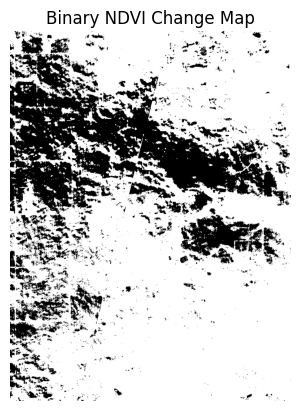

✅ Converted patch to OSCD-style dataset under: OSCD/crop_rotation/occitanie_crop_rotation


In [26]:
# # Sample: Occitanie, France

# Location: (43.6117, 1.4526)

# Dates: 2020-04-01 → 2020-09-15

bbox_coords = (43.6117, 1.4526, 43.7117, 1.5526)  
save_dir = "./data/patches/crop_rotation_occitanie_2020/"
date_old = "2020-04-01"
date_new = "2020-09-15"
save_path = "./data/patches/crop_rotation_occitanie_2020/change_map.png"

# Source and destination directories
src_dir = "data/patches/crop_rotation_occitanie_2020"
dst_dir = "OSCD/crop_rotation/occitanie_crop_rotation"

i1="data/patches/crop_rotation_occitanie_2020/2020-04-01.npy"
i2="data/patches/crop_rotation_occitanie_2020/2020-09-15.npy"

# Load .npy images
img_1 = "2020-04-01.npy"
img_2 = "2020-09-15.npy"

get_images(bbox_coords)
save_image(save_dir, date_old, date_new, save_path, i1, i2)
convert_oscd(src_dir, dst_dir, img_1, img_2)

Saved ./data/patches/crop_rotation_punjab_2020/2020-03-01.npy
Saved ./data/patches/crop_rotation_punjab_2020/2020-10-01.npy
Done! You can now generate a binary change map from these two .npy files.
Old shape: (13, 1104, 837)
New shape: (13, 1104, 837)
Change map shape: (1104, 837)


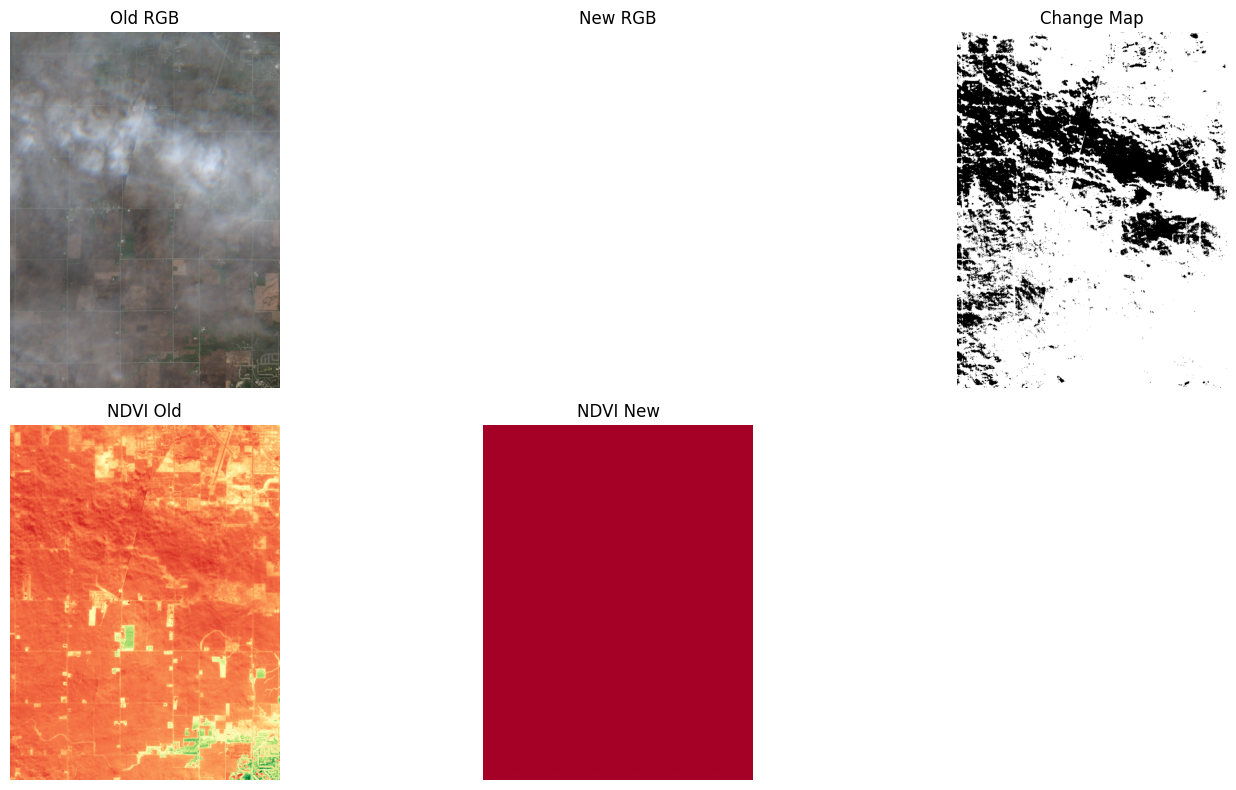

✅ Converted patch to OSCD-style dataset under: OSCD/crop_rotation/punjab_crop_rotation


In [66]:
# # Sample: Punjab, India

# Location: (30.9004, 75.8573)

# Dates: 2020-04-01 → 2020-10-01

bbox_coords = (30.9004, 75.8573, 31.1004, 76.0573)  
save_dir = "./data/patches/crop_rotation_punjab_2020/"
date_old = "2020-03-01"
date_new = "2020-10-01"
save_path = "./data/patches/crop_rotation_punjab_2020/change_map.png"

# Source and destination directories
src_dir = "data/patches/crop_rotation_punjab_2020"
dst_dir = "OSCD/crop_rotation/punjab_crop_rotation"

i1="data/patches/crop_rotation_punjab_2020/"+date_old+".npy"
i2="data/patches/crop_rotation_punjab_2020/"+date_new+".npy"

# Load .npy images
img_1 = date_old+".npy"
img_2 = date_new+".npy"

get_images(bbox_coords)
save_image(save_dir, date_old, date_new, save_path, i1, i2)
convert_oscd(src_dir, dst_dir, img_1, img_2)

Saved ./data/patches/crop_rotation_matogrosso_2020/2020-05-01.npy
Saved ./data/patches/crop_rotation_matogrosso_2020/2020-10-15.npy
Done! You can now generate a binary change map from these two .npy files.
Old shape: (13, 1104, 837)
New shape: (13, 1104, 837)
Change map shape: (1104, 837)


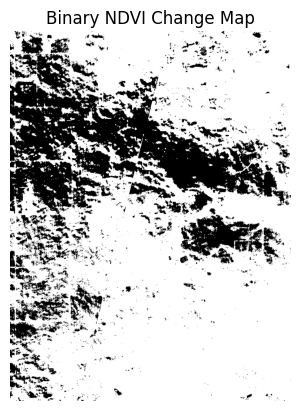

✅ Converted patch to OSCD-style dataset under: OSCD/crop_rotation/matogrosso_crop_rotation


In [28]:
# # Sample: Mato Grosso, Brazil

# Location: (-12.9731, -55.9621)

# Dates: 2020-05-01 → 2020-10-15   

    bbox_coords = (-12.9731, -55.9621, -12.8731, -55.8621)  
save_dir = "./data/patches/crop_rotation_matogrosso_2020/"
date_old = "2020-05-01"
date_new = "2020-10-15"
save_path = "./data/patches/crop_rotation_matogrosso_2020/change_map.png"

# Source and destination directories
src_dir = "data/patches/crop_rotation_matogrosso_2020"
dst_dir = "OSCD/crop_rotation/matogrosso_crop_rotation"

i1="data/patches/crop_rotation_matogrosso_2020/2020-05-01.npy"
i2="data/patches/crop_rotation_matogrosso_2020/2020-10-15.npy"

# Load .npy images
img_1 = "2020-05-01.npy"
img_2 = "2020-10-15.npy"

get_images(bbox_coords)
save_image(save_dir, date_old, date_new, save_path, i1, i2)
convert_oscd(src_dir, dst_dir, img_1, img_2)

Saved ./data/patches/crop_rotation_beuce_2020/2021-08-15.npy
Saved ./data/patches/crop_rotation_beuce_2020/2022-03-20.npy
Done! You can now generate a binary change map from these two .npy files.
Old shape: (13, 1104, 837)
New shape: (13, 1104, 837)
Change map shape: (1104, 837)


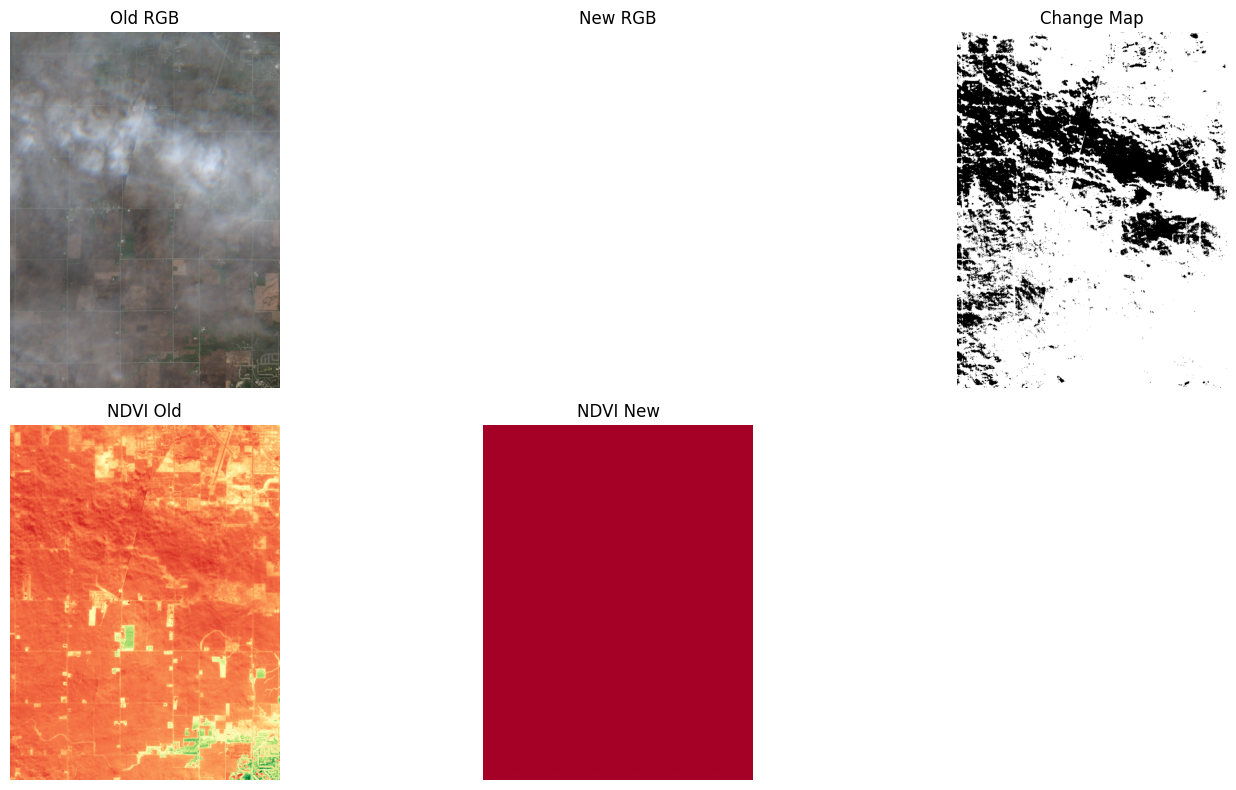

✅ Converted patch to OSCD-style dataset under: OSCD/crop_rotation/beuce_crop_rotation


In [77]:
# # Sample:  Beauce, France

# Known for intensive cereal farming and rotational crops.

# Low cloud cover, easy access on SentinelHub.

# Location: 48.3°N, 1.5°E
bbox_coords = (48.30, 1.50, 48.40, 1.60) 
save_dir = "./data/patches/crop_rotation_beuce_2020/"
date_old = "2021-08-15"
date_new = "2022-03-20"
save_path = "./data/patches/crop_rotation_beuce_2020/change_map.png"

# Source and destination directories
src_dir = "data/patches/crop_rotation_beuce_2020"
dst_dir = "OSCD/crop_rotation/beuce_crop_rotation"

i1="data/patches/crop_rotation_beuce_2020/"+date_old+".npy"
i2="data/patches/crop_rotation_beuce_2020/"+date_new+".npy"

# Load .npy images
img_1 = date_old+".npy"
img_2 = date_new+".npy"

get_images(bbox_coords)
save_image(save_dir, date_old, date_new, save_path, i1, i2)
convert_oscd(src_dir, dst_dir, img_1, img_2)

#save_image_one(save_dir, date_old, save_path, i1)
#save_image_one(save_dir, date_new, save_path, i2)
#process_image(i1, i2)